In [28]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
from scipy.stats import distributions

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# functions to compute various NRMSEs
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('time')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [3]:
def get_vpd(humidity_data, tas_data):
    svp = .6112 * np.exp(17.76*tas_data/(tas_data + 243.5))
    vpd = svp * (1 - humidity_data/100)
    return vpd/1000

In [4]:
# computes t-test for differences
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

## Calculate VPD, then make predictions

In [5]:
hurs245 = xr.open_dataset('vpd_data/hurs_ssp245.nc')
tas245 = xr.open_dataset('vpd_data/tas_ssp245.nc')
vpd245 = get_vpd(hurs245.hurs, tas245.tas).to_dataset(name='vpd')

C:\Users\kaits\anaconda3\Lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
train_scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']

In [7]:
hursTrain = xr.concat([xr.open_dataset(f'vpd_data/hurs_{s}.nc') for s in train_scenarios]
    , dim='time')
tasTrain = xr.concat([xr.open_dataset(f'vpd_data/tas_{s}.nc') for s in train_scenarios]
    , dim='time')

In [8]:
Xtrain = get_vpd(hursTrain.hurs, tasTrain.tas).to_dataset(name='vpd')

In [9]:
# average data over ensemble members
ytrain = xr.concat(
    [xr.open_dataset(f'train_val/outputs_{s}.nc').mean('member') for s in train_scenarios]
    , dim='time')

# mean temp averaged globally and over training simulations
weights = np.cos(np.deg2rad(ytrain.lat))
global_mean_temp = ytrain['tas'].weighted(weights).mean(['lat', 'lon']).to_numpy().reshape(-1,1)

In [10]:
ytest = xr.open_dataset(f'test/outputs_ssp245.nc')
for out in ['tas', 'pr', 'pr90', 'diurnal_temperature_range']:
    ytest[out] = ytest[out].mean('member')

In [11]:
# get mean temperature averaged globally
test_input = (ytest['tas']
              .weighted(weights)
              .mean(['lat', 'lon'])
              .to_pandas() # convert to pandas to use rolling average
              .rolling(10, min_periods=1)
              .mean()
              .to_numpy() # convert back to numpy to reshape
              .reshape(-1,1))

In [12]:
# create model
model_vpd = LinearRegression(fit_intercept=False)
model_vpd.fit(global_mean_temp, Xtrain.vpd.stack(dim=['lat','lon']))

LinearRegression(fit_intercept=False)

In [13]:
output_vpd = model_vpd.predict(test_input).reshape(86,96,144)

Now we fit a model predicting variables, then using it to calculate VPD.

In [14]:
model_hurs = LinearRegression(fit_intercept=False)
model_hurs.fit(global_mean_temp, hursTrain.hurs.stack(dim=['lat','lon']))

LinearRegression(fit_intercept=False)

In [15]:
model_tas = LinearRegression(fit_intercept=False)
model_tas.fit(global_mean_temp, tasTrain.tas.stack(dim=['lat','lon']))

LinearRegression(fit_intercept=False)

In [16]:
output_hurs = model_hurs.predict(test_input).reshape(86,96,144)
output_tas = model_tas.predict(test_input).reshape(86,96,144)

In [17]:
output_postvpd = get_vpd(output_hurs, output_tas)

In [18]:
nrmses = [
    [
        get_nrmse_spatial(vpd245.vpd, out), 
        get_nrmse_global(vpd245.vpd, out),
        get_nrmse(vpd245.vpd, out)
    ] 
    for out in [output_vpd, output_postvpd]
]

nrmse_table = pd.DataFrame(data=nrmses, index=['vpd_first', 'vpd_last'], columns=['spatial', 'global', 'total']).round(3)
nrmse_table

,spatial,global,total
vpd_first,0.051,0.053,0.317
vpd_last,0.119,0.084,0.538


It appears better to compute VPD first, then use it to make predictions.

In [37]:
# turn output into dataarray to plot
xr_output=xr.Dataset(
    coords={'time': ytest.time.values, 'lat': ytest.lat.values, 'lon': ytest.lon.values})

xr_output['vpd'] = (['time', 'lat', 'lon'], output_vpd)

In [32]:
p_level = 0.05
proj = ccrs.PlateCarree() 

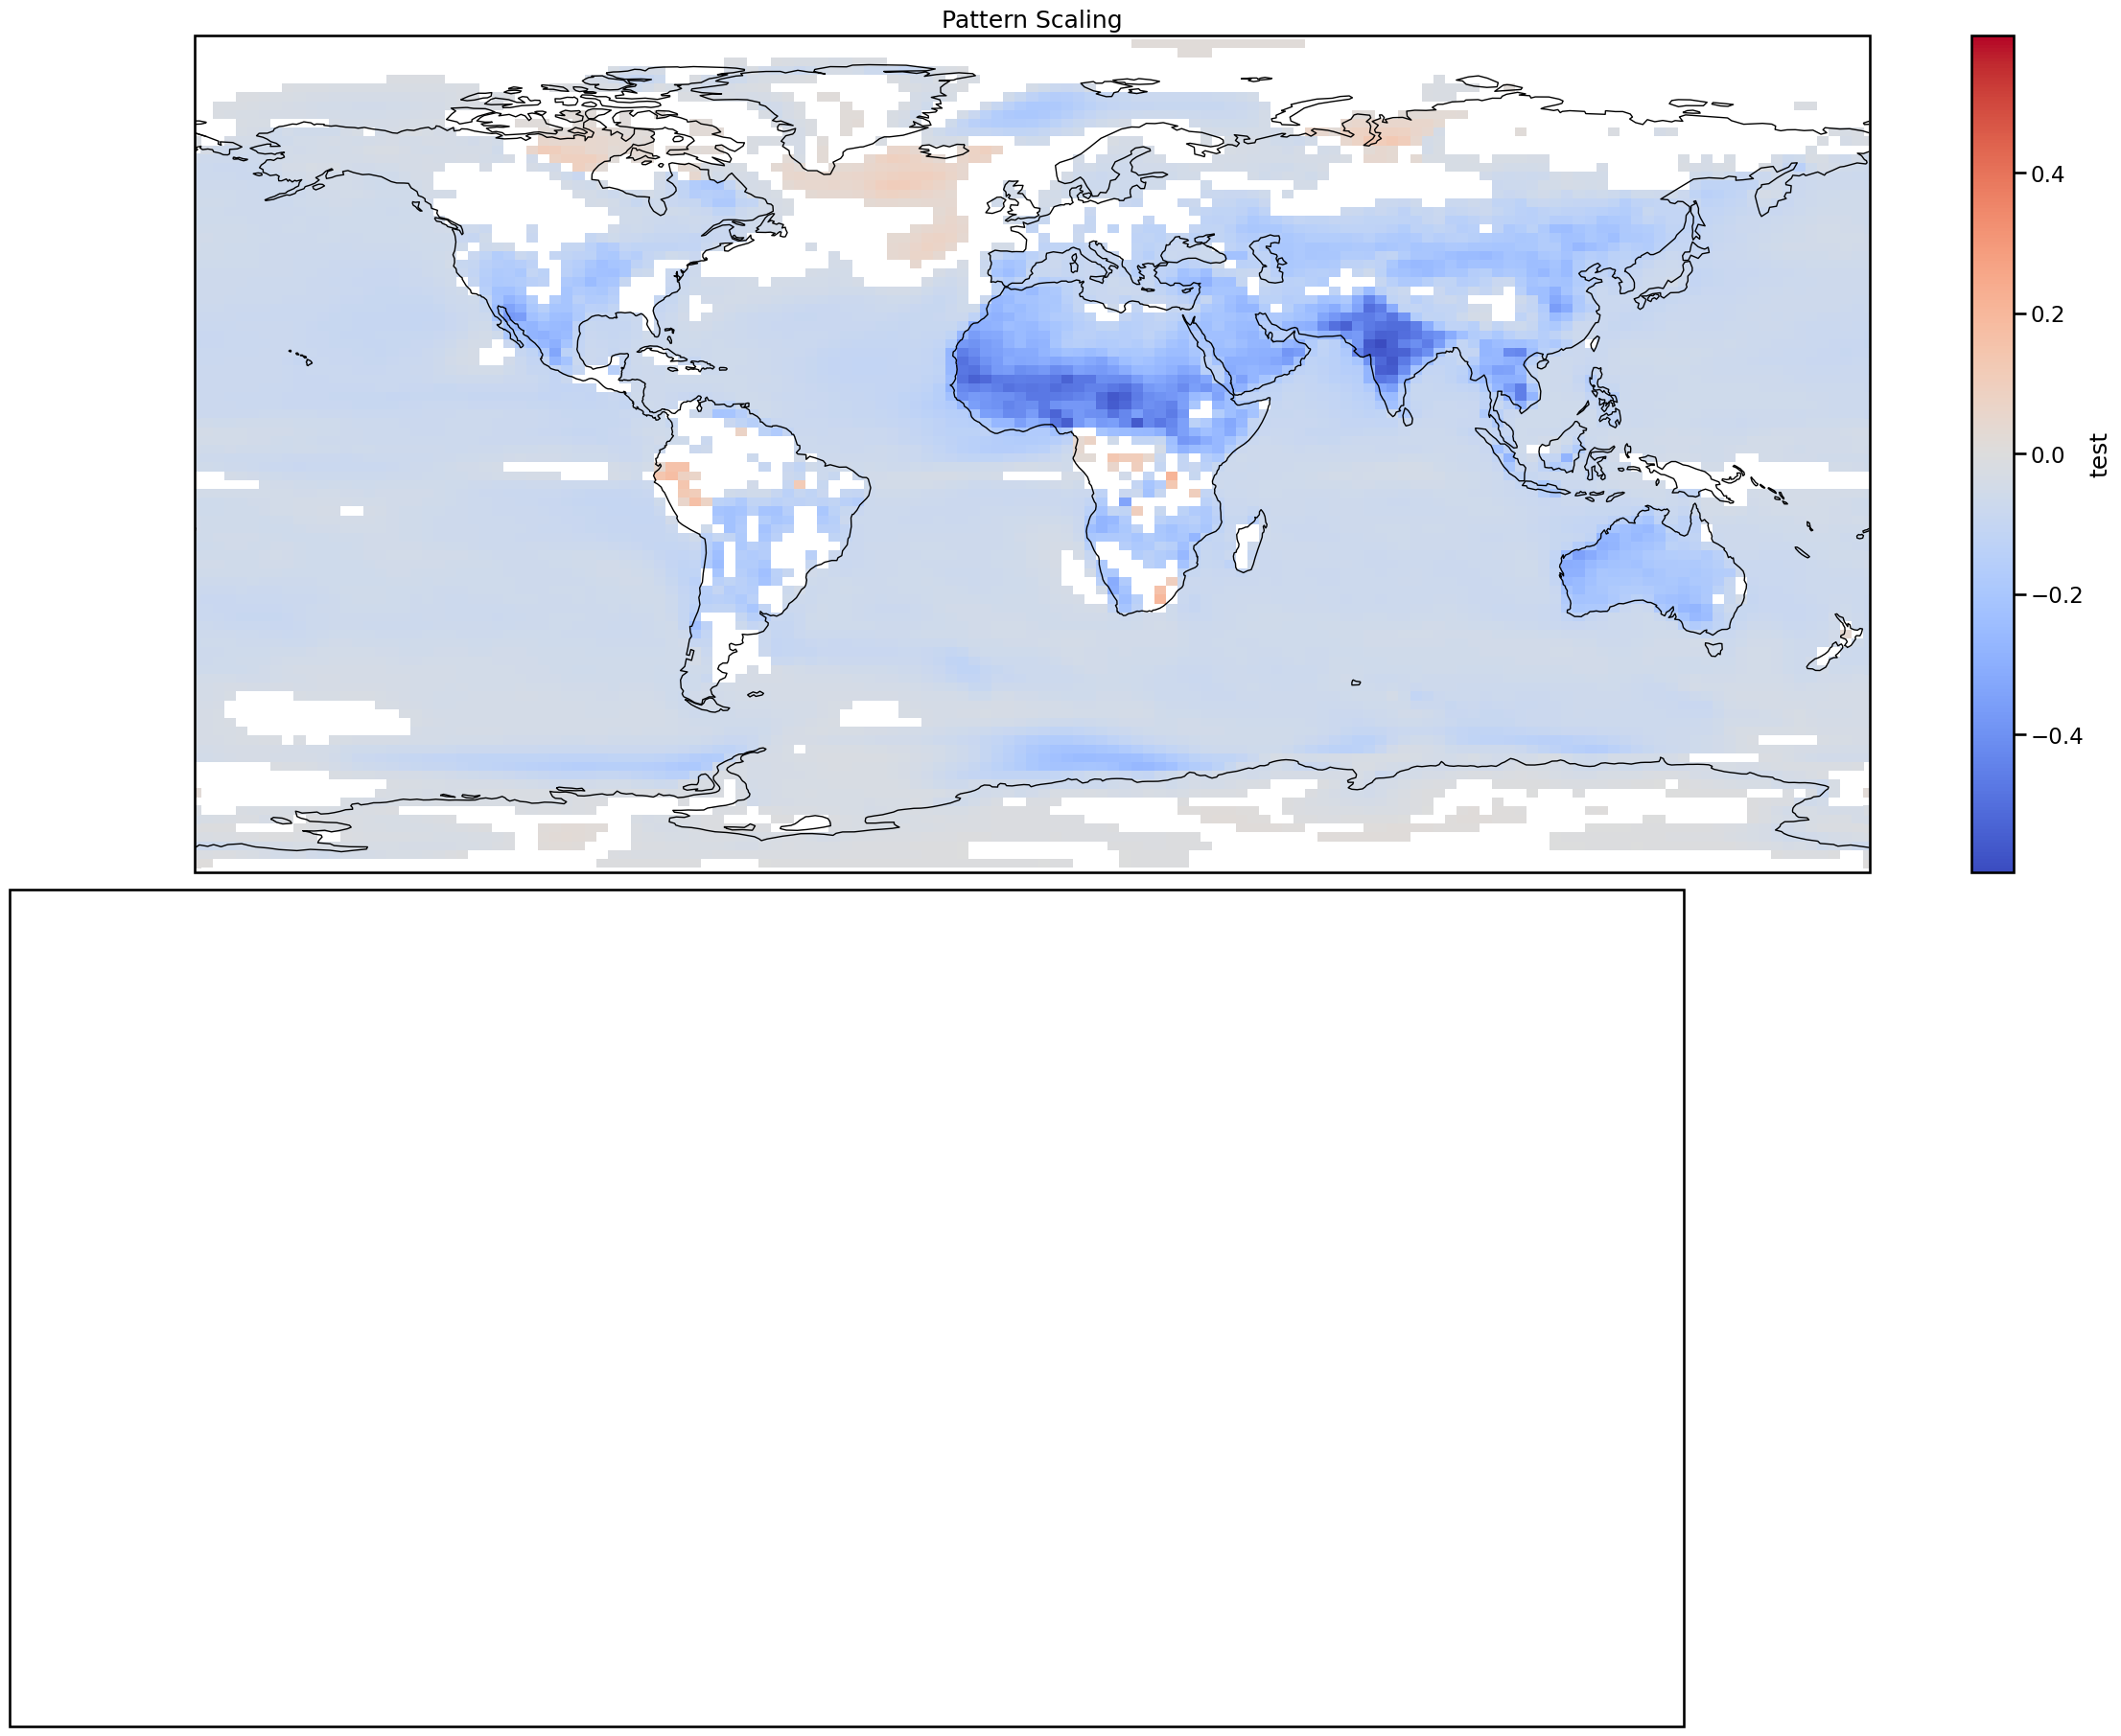

In [38]:
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(2, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    for i in range(1):
        out = 'vpd'
        diff = xr_output[out][-21:] - vpd245[out][-21:]
        ax = axes[i]
        
        ax.set_title('Pattern Scaling')
        mean_diff = diff.mean('time')
        _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
        
        (mean_diff.where(p < p_level)
                  .plot(
                     cmap="coolwarm", 
                     ax=ax, 
                     add_labels=False, 
                     transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"label":"test", "orientation":'vertical'}))
        ax.coastlines()